In [190]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import json

In [191]:
model_type = 'adversarial'         # 'standard', 'robust', 'adversarial'
norm = 2                       # 1, 2, np.inf
max_iterations = 500            # maximum number of iterations for the PGD attack
nb_batch = 500                  # number of batches for clever score computation
batch_size = 1024               # batch size for clever score computation

In [192]:
if model_type=='adversarial':
    norm = 2
    max_iterations = 10000

In [193]:
file_path = f'../data/paper_data/adv_dist_vs_clever_{model_type}_500.json'

# load the data
with open(file_path, 'r') as f:
    results_dict = json.load(f)

In [194]:
clever_values = results_dict[f'{norm}']['clever_score'][f'{nb_batch}-{batch_size}']
max_adversarial_distance = results_dict[f'{norm}']['max_adversarial_distance']  

In [195]:
min_attack_value, colors_attack, colors_clever = [], [], []

for i in range(len(results_dict[f"{norm}"]['adversarial_distance_pgd'])):
    
    #Misclassified inputs
    if results_dict[f"{norm}"]['adversarial_distance_pgd'][i]==0.0 and results_dict[f"{norm}"]['adversarial_distance_second_attack'][i]==0.0:
        colors_attack.append('blue')
        colors_clever.append('black')
        clever_values[i] = None
        min_attack_value.append(0.0)

    # Both attacks unsuccessful
    elif model_type=='adversarial' and results_dict[f"{norm}"]['iterations_pgd'][i] == (max_iterations - 1) and results_dict[f"{norm}"]['adversarial_distance_second_attack'][i] == 0.0:
        colors_attack.append('blue')
        colors_clever.append('black')
        min_attack_value.append(max_adversarial_distance)
    
    # CW is None but PGD works
    elif model_type=='adversarial' and results_dict[f"{norm}"]['iterations_pgd'][i] < (max_iterations - 1) and results_dict[f"{norm}"]['adversarial_distance_second_attack'][i] == 0.0:
        colors_attack.append('blue')
        min_attack_value.append(results_dict[f"{norm}"]['adversarial_distance_pgd'][i])
        if results_dict[f'{norm}']['clever_score'][f'{nb_batch}-{batch_size}'][i]>results_dict[f"{norm}"]['adversarial_distance_pgd'][i]:
            colors_clever.append('red')
        else:
            colors_clever.append('black')
    
    # PGD is None but CW works
    elif model_type=='adversarial' and results_dict[f"{norm}"]['iterations_pgd'][i] == (max_iterations - 1) and results_dict[f"{norm}"]['adversarial_distance_second_attack'][i] > 0.0:
        colors_attack.append('green')
        min_attack_value.append(results_dict[f"{norm}"]['adversarial_distance_second_attack'][i])
        if results_dict[f'{norm}']['clever_score'][f'{nb_batch}-{batch_size}'][i]>results_dict[f"{norm}"]['adversarial_distance_second_attack'][i]:
            colors_clever.append('red')
        else:
            colors_clever.append('black')
        
    # take min of two
    else:
        if results_dict[f"{norm}"]['adversarial_distance_second_attack'][i]<results_dict[f"{norm}"]['adversarial_distance_pgd'][i] and results_dict[f"{norm}"]['adversarial_distance_second_attack'][i]>0.0:
            colors_attack.append('green')
            min_attack_value.append(results_dict[f"{norm}"]['adversarial_distance_second_attack'][i])
        else:    
            colors_attack.append('blue')
            min_attack_value.append(results_dict[f"{norm}"]['adversarial_distance_pgd'][i])
        
        if min_attack_value[i]>=results_dict[f'{norm}']['clever_score'][f'{nb_batch}-{batch_size}'][i]:
            colors_clever.append('black')
        else:
            colors_clever.append('red')

In [196]:
sorted_indices = np.argsort(min_attack_value)
min_attack_value_sorted = np.array(min_attack_value)[sorted_indices].tolist()
clever_values_sorted = np.array(clever_values)[sorted_indices].tolist()
colors_attack_sorted = np.array(colors_attack)[sorted_indices].tolist()
colors_clever_sorted = np.array(colors_clever)[sorted_indices].tolist()

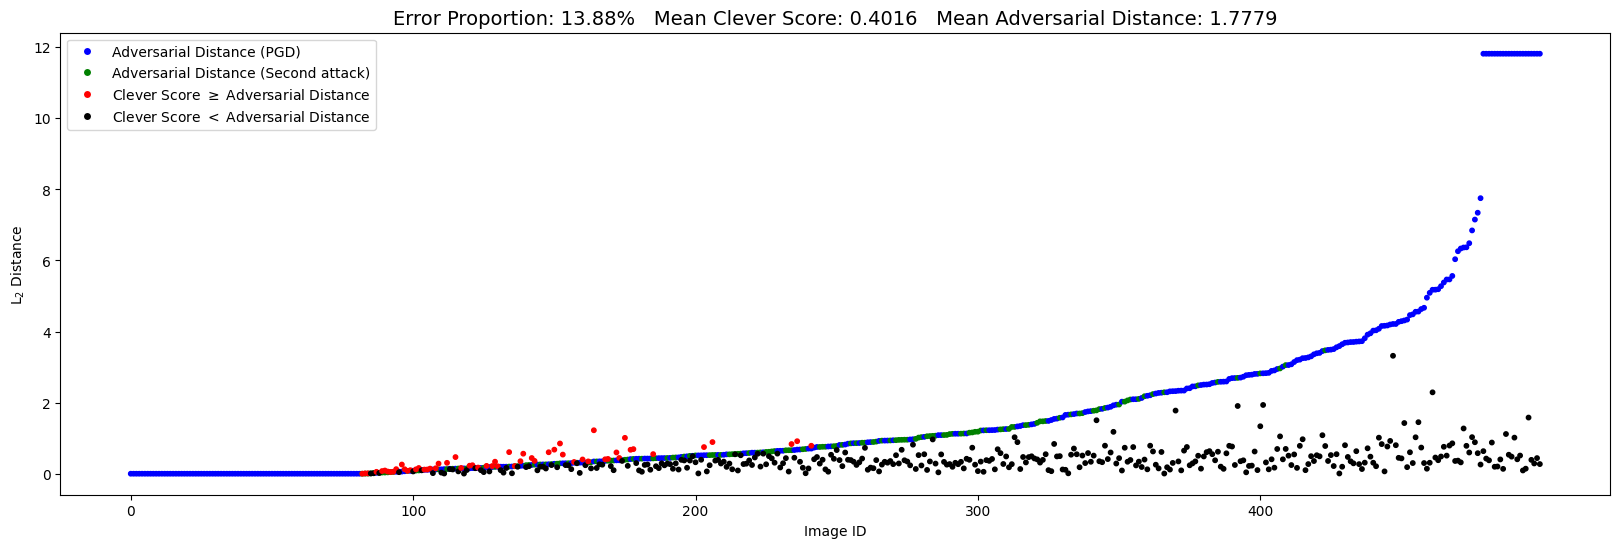

In [197]:
# Calculate the error proportion
total_points = 0
red_points = 0

image_ids = np.arange(len(min_attack_value))

for i in range(len(image_ids)):
    if clever_values_sorted[i] is not None:
        total_points += 1
        if clever_values_sorted[i] > min_attack_value_sorted[i]:
            red_points += 1

error_proportion = (red_points / total_points) * 100 if total_points > 0 else 0

mean_clever_score = np.mean([x for x in clever_values_sorted if x is not None and np.isnan(x)==False])
mean_min_attack_value = np.mean([x for x in min_attack_value_sorted if np.isnan(x)==False])

# Plotting
marker_size = 10
# plt.figure(figsize=(4.69, 2.17))
plt.figure(figsize=(20, 6))
plt.scatter(image_ids, min_attack_value_sorted, color=colors_attack_sorted, s=marker_size)
plt.scatter(image_ids, clever_values_sorted, color=colors_clever_sorted, s=marker_size)
# Adding labels and title with error proportion
plt.xlabel('Image ID', fontsize=10)
plt.ylabel(f'L$_{norm}$ Distance', fontsize=10)
plt.title(f'Error Proportion: {error_proportion:.2f}%   Mean Clever Score: {mean_clever_score:.4f}   Mean Adversarial Distance: {mean_min_attack_value:.4f}', fontsize=14)
plt.xticks(np.arange(0, len(sorted_indices), 100), fontsize=10)
plt.yticks(fontsize=10)
# Avoid label duplication in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='Adversarial Distance (PGD)'),
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Adversarial Distance (Second attack)'),
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Clever Score $\geq$ Adversarial Distance'),
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='Clever Score $<$ Adversarial Distance')
]

plt.legend(handles=legend_elements, fontsize=10)
# plt.savefig(f'../data/paper_data/adv_dist_vs_clever_{model_type}_500_L{norm}.pdf')
plt.show()